# **Deep Learning Assignment**

The CIFAR10 dataset consists of 60000 (3x32x32) color images and 10 classes. The classes are: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The aim of this project is to implement a CNN model capable of classifying the images with an accuracy higher than 70% on the validation set.

The report will be divided in 5 parts:

1. Reading the dataset and creating data loaders

2. Creating the block for the model and teh model

3. Creating the loss, optimizer and rate scheduler

4. Traning and evaluating model, creating test and validation loops

5. Plotting curves for the evolution of the loss and the training and validation accuracies

## 1. Reading dataset and creating data loaders

In this section the code serves to: import the necessary libraries, load the dataset and dataloaders, perform transformations on the data, print and count the classes and visualise some images from the dataset.

Using dataloaders allows to preprocess and load the data in batches. The data is preprocessed using techniques such as normalization, random rotation and random horizontal flip.

In [1]:
# 1) Importing libraries
import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt

In [2]:
# 2) Load dataset

# Transformations of the data
cifar_transform_train = transforms.Compose([transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar_transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 64

# training data
cifar_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_transform_train)
cifar_train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=2)

# validation data
cifar_val = datasets.CIFAR10(root='./data', train=False, download=True, transform=cifar_transform_val)
cifar_val_loader = DataLoader(cifar_val, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# 3) Print the classes

classes = cifar_train.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [4]:
# Count classes

class_count = {}
for _, index in cifar_train:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
class_count

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

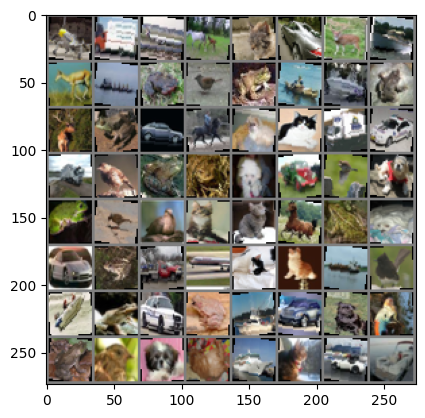

In [5]:
# Visualise images

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(cifar_train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

## 2. Creating the block for the model and the model

The class for the block is define as 'Block'. The input to the block is a 4D tensor, ***x***, with the shape: (batch_size, in_channels, height, width). And ***k*** represents number of parallel convolutional layers. Each convolutional layer is followed by a ReLU activation function.

In this case, **__innit__** serves to initialise the following parameters and layers: self.spatial_avg_pool, self.linear, self.spatial_avg_pool, self.fl, self.spatial_avg_pool, self.out_channels, self.Batch_norm_conv, self.activation and self.maxpool. 

The **forward** method is used to compute *a*, which is a 3D tensor of size: (batch_size, 1, k). *a* is obtained by making the output of self.spatial_avg_pool pass through self.fl, self.linear and self.activation. Then, the outputs of all the convolutional layers (k) are stacked to get a 5D tensor with the shape: (batch_size, k, out_channels, height, width). This is reshaped to a 3D tensor of shape (batch_size, k, out_channels * height * width). Then, we compute the sum of the product of this final tensor multiplied by tenson ***a*** along the ***k*** dimension. The ouoput of this is a 3D tensor with shape: (batch_size, out_channels, height, width). Finally, a ReLU activation is applied to this output and the max pooling layer is applied to this output to reduce the spatial dimensions. 

In [6]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, k):
        super(Block, self).__init__()
        self.spatial_avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(in_channels, k)
        self.fl=nn.Flatten()
        self.out_channels=out_channels
        self.k=k
        self.Batch_norm_conv=nn.BatchNorm2d(self.out_channels)
        self.activation = nn.ReLU(inplace=True)
        self.maxpool=nn.MaxPool2d(kernel_size=2)
        for i in range(k):
            self.add_module('conv{0}'.format(i), nn.Conv2d(in_channels, 
                                                           out_channels, kernel_size=3, padding=1))
            self.add_module('relu{0}'.format(i), nn.ReLU())

    def forward(self, x):
        conv_list=[]
        conv_dict={}
        batch_size=x.shape[0]
        a = self.activation(self.linear(self.fl(self.spatial_avg_pool(x))))
        a=a.reshape(batch_size,1,-1)
        for i in range(self.k):
          conv_dict[i]=self._modules['conv{0}'.format(i)](x)
          conv_dict[i]=self._modules['relu{0}'.format(i)](conv_dict[i])
          conv_list.append(conv_dict[i])
        convo_stack=torch.stack(conv_list, dim=1)
        convo_stack_reshape=torch.stack(conv_list, dim=1).reshape(batch_size,self.k,-1)
        linear_wieghting_1=torch.matmul(a,convo_stack_reshape).reshape(batch_size,self.out_channels,32,32)
        linear_wieghting_1=self.activation(linear_wieghting_1)

        return linear_wieghting_1


In [7]:
# Setting parameters
in_channels=3
out_channels=64
k=3
block=Block(in_channels, out_channels,k)

This module is called *Valnet* and serves to implement the CNN classification model. The architecture of this CNN is set using the *conv_arch* parameters, and the parameters are specified after the first block of code. The *conv_arch* parameter contains a list of tuples (k, out_channels) that specifies the number of parallel convolutional layers and output chanel for each of the blocks. 

The ***__innit__*** method initializes the following layers and parameters: in_channels, self.conv_arch, self.spatial_avg_pool, self.last. For each block of the CNN, this module initialises a new instance of the Block class (as defined before). The input channels for each blosk is set to the output channels of the previous block.

The ***forward*** method is used to: initialise *out* to be the same as the input tensor *x*, compute the output of each block in the CNN using *out*, use average pooling on the output of the last block to reduce its dimensions to 1x1 and flatten this last output. Finally, this last flattened tensor is passed through the fully connected layer to get the final outputs (classifications). 


In [8]:
class Valnet(nn.Module):
    def __init__(self, conv_arch):
        super(Valnet, self).__init__()
        in_channels = 3
        self.conv_arch = conv_arch
        self.spatial_avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
        for i, (k, out_channels) in enumerate(conv_arch):
            self.add_module('block{0}'.format(i), Block(in_channels, out_channels, k))
            in_channels = out_channels
        self.last = nn.Sequential(nn.Flatten(), nn.Linear(256, 10))


    def forward(self, x):
        out = x
        for i in range(len(self.conv_arch)):
            out = self._modules['block{0}'.format(i)](out)
        out=self.spatial_avg_pool(out)
        out = self.last(out)
        return out

In [9]:
# Parameters for conv_arch
conv_arch = ((3, 64), (3, 128), (3, 256))

In [10]:
# Passing the model through conv_arch and naming it model
model=Valnet(conv_arch)

In [11]:
# Printing the model
model

Valnet(
  (spatial_avg_pool): AdaptiveAvgPool2d(output_size=1)
  (block0): Block(
    (spatial_avg_pool): AdaptiveAvgPool2d(output_size=1)
    (linear): Linear(in_features=3, out_features=3, bias=True)
    (fl): Flatten(start_dim=1, end_dim=-1)
    (Batch_norm_conv): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU()
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (block1): Block(
    (spatial_avg_pool): AdaptiveAvgPool2d(output_size=1)
    (linear): Linear(in_features=64, out_features=3, bias=True)
    (fl): Flatten(start_dim=1, end_dim=-1)
    (Batch_norm_conv): BatchNorm2d(128, eps=

## 3. Creating the loss, optimizer and rate scheduler

In this case, the specificed device is GPU so the model can run faster. 

The hyperparameters defined are: num_epochs, learning_rate, weight_decay, milestones and gamma. 

This code also sets the loss function (criterion), optimizer, and learning rate scheduler. In this case, the loss function used is cross-entropy loss, the optimizer is Adam and the learning rate is used to adjust and update the learning rate after a set number of epochs (in the list). It reduces the learning rate by a factor of gamma at each of the milestone specified in 'milestones'. 

In [13]:
# Device settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Hyperparameters
num_epochs = 50
learning_rate = 0.001
weight_decay = 1e-4
milestones = [30,35,40,45,50]
gamma = 0.5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

## 4. Traning and evaluating model, creating test and validation loops

The **training process** consisted of experimenting with diferent hyperparamenters and some parts of the block and model and evaluating the results of each experiment with the aim of achieving the best possible accuracy on the validation set. 

The methodology to test different results was to create different notebooks to try out different changes on the architecture and hyperparameters and compare the results between the models to try and understand which techniques would work best. In general, since vectorisation was used to construct the different parts of the model, the model would take around 40 min to run 50 epochs. If the accuracy on the first epoch was than 0.2, that model was rejected and different changes were applied. 

There were 13 different versions of this model arquitecture. The model presented on this report is the one that achieved the best results.

The initial hyperparameter values were set to: 

**num_epochs** = 50

**learning_rate** = 0.0001

**weight_decay** = 1e-4

**batch_size** = 128

The hyperparameters of milestones and gamma were added later. Orginally gamma was set to 0.6 and milestoles had less values on its list. At the beggining, a ReLU was not included on the Block after the stacking and SDG was used instead of Adam. In general, increasing teh architecture by adding more than 3 blocks or changin the value for the value of k would cause the model not to learn. Moreover, the initial models did not contain the conv_arch parameter.

On the first models, when When k =3, the epoch 26th/50 of the train and validation sets achieves accuracy stop increasing at 0.69 and only slowly increase at epoch 29/50. If k was set to higher values, the train and validation accuracy would only start at 0.12, so 3 was final the value for k. Initially, the batch size was set to 128, but smaller sized seemed to perform better.

A learning rate of 0.01 seemed to cause overfitting, so 0.001 was the value that achieved best performances. 

The final hyperparameters (along with the changes in the arquitecture previously mentioned) are:

**num_epochs** = 50

**learning_rate** = 0.001

**weight_decay** = 1e-4

**milestones** = [30, 35, 40, 45, 50]

**gamma** = 0.5

**conv_arch** = ((3, 64), (3, 128), (3, 256))

**batch_size** = 64

The following code defines a function that trains the model on the specified dataset, loss function, optimizer and devide. This function iterates over batches generated in the dataloader and serves to compute the loss, gradient values and update the model parameters using the specified optimizer.

In [14]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)
    scheduler.step()
    print("Epoch %d: SGD lr=%.8f" % (epoch, optimizer.param_groups[0]["lr"]))
    return running_loss / len(dataloader.dataset), correct.double() / len(dataloader.dataset)


The code below defines a function that evaluates the model on the given dataset, loss function and device. It returns the average loss and accuracy over the entire dataset. The function iterates over batches in the dataloader, calculates accuracy and loss and returns the average loss and accuracy on the complete dataset.

In [15]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
    return running_loss / len(dataloader.dataset), correct.double() / len(dataloader.dataset)


The code below uses a for loop to train the model on the number of epochs set at the beginning. The loop calls the train fintion to train the model on the training set and the evaluate function to evaluate the model on the validation set. It does this iteratively. All these results are recorded at each epoch and printed out (train and validation loss and accuracy, epoch and learning rate).

The final results achived are: 

**Epoch**: 50/50

**Training loss**: 0.32

**Training accuracy**: 0.88

**Validation loss**:0.65

**Validation accuracy**: 0.81

**Learning rate**: 0.00003

In [16]:
train_loss_list=[]
train_acc_list=[]
val_acc_list=[]

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, cifar_train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, cifar_val_loader, criterion, device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 0: SGD lr=0.00100000
Epoch 0/50
Train Loss: 1.9072, Train Acc: 0.2732
Val Loss: 1.6949, Val Acc: 0.3623
Epoch 1: SGD lr=0.00100000
Epoch 1/50
Train Loss: 1.6328, Train Acc: 0.3903
Val Loss: 1.5609, Val Acc: 0.4219
Epoch 2: SGD lr=0.00100000
Epoch 2/50
Train Loss: 1.5273, Train Acc: 0.4366
Val Loss: 1.4460, Val Acc: 0.4741
Epoch 3: SGD lr=0.00100000
Epoch 3/50
Train Loss: 1.4243, Train Acc: 0.4820
Val Loss: 1.4108, Val Acc: 0.4855
Epoch 4: SGD lr=0.00100000
Epoch 4/50
Train Loss: 1.3345, Train Acc: 0.5172
Val Loss: 1.2861, Val Acc: 0.5361
Epoch 5: SGD lr=0.00100000
Epoch 5/50
Train Loss: 1.2575, Train Acc: 0.5504
Val Loss: 1.1906, Val Acc: 0.5736
Epoch 6: SGD lr=0.00100000
Epoch 6/50
Train Loss: 1.1838, Train Acc: 0.5772
Val Loss: 1.1429, Val Acc: 0.5808
Epoch 7: SGD lr=0.00100000
Epoch 7/50
Train Loss: 1.1224, Train Acc: 0.6004
Val Loss: 1.1079, Val Acc: 0.6043
Epoch 8: SGD lr=0.00100000
Epoch 8/50
Train Loss: 1.0627, Train Acc: 0.6218
Val Loss: 1.0689, Val Acc: 0.6194
Epoch 9: S

## 5. Plotting curves for the evolution of the loss and the training and validation accuracies

Finally, the curves for the loss, training accuracu and testing accuracy over the number of epochs can be plotted using the matplotlib library and a list containg the final results generated in the code before.

The training accuracy is 88.78800000000001 %
The testing accuracy is 81.16 %


<ipython-input-20-51049be036c3>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_loss_list = torch.tensor(train_loss_list, device = 'cpu')
<ipython-input-20-51049be036c3>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_acc_list = torch.tensor(train_acc_list, device = 'cpu')
<ipython-input-20-51049be036c3>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_acc_list = torch.tensor(val_acc_list, device = 'cpu')


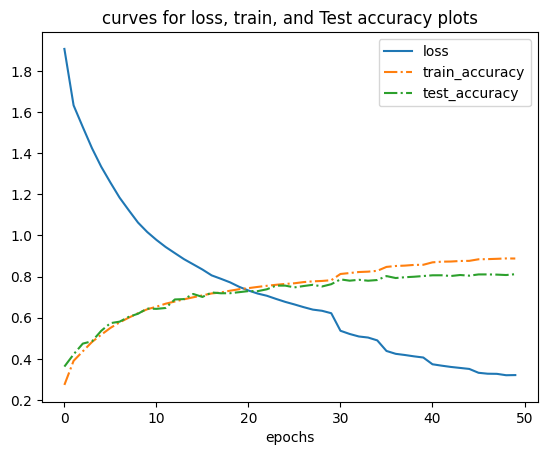

In [20]:
print('\033[1m'+"The training accuracy is {} %".format(train_acc_list[-1]*100)+'\033[0m')
print('\033[1m'+"The testing accuracy is {} %".format(val_acc_list[-1]*100)+'\033[0m')
epochs=[i for i in range(num_epochs)]
train_loss_list = torch.tensor(train_loss_list, device = 'cpu')
train_acc_list = torch.tensor(train_acc_list, device = 'cpu')
val_acc_list = torch.tensor(val_acc_list, device = 'cpu')
plt.plot(epochs, train_loss_list, label ='loss')
plt.plot(epochs, train_acc_list, '-.', label ='train_accuracy')
plt.plot(epochs, val_acc_list, '-.', label ='test_accuracy')
plt.xlabel("epochs")
plt.legend()
plt.title('curves for loss, train, and Test accuracy plots')
plt.show()